In [5]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["figure.figsize"] = (12,5)

In [12]:
# def bound(args, num_male, num_female):
#     return args.LR*(2*args.clip+8*args.clip**2*args.ns**2)/2
bound = 0.001*(2*1 + 8*1**2*1**2)/2

In [6]:
with open('results/dict/adult_fair_fold_0_9112022_102956.pkl', 'rb') as f:
    run_fair_dict = pickle.load(f)
with open('results/dict/adult_proposed_fold_0_9112022_103013.pkl', 'rb') as f:
    run_proposed_dict = pickle.load(f)

In [9]:
run_fair_dict.keys()

dict_keys(['train_global_history_loss', 'train_male_history_loss', 'train_female_history_loss', 'train_global_history_acc', 'train_male_history_acc', 'train_female_history_acc', 'val_global_history_loss', 'val_male_history_loss', 'val_female_history_loss', 'val_global_history_acc', 'val_male_history_acc', 'val_female_history_acc', 'male_norm', 'female_norm'])

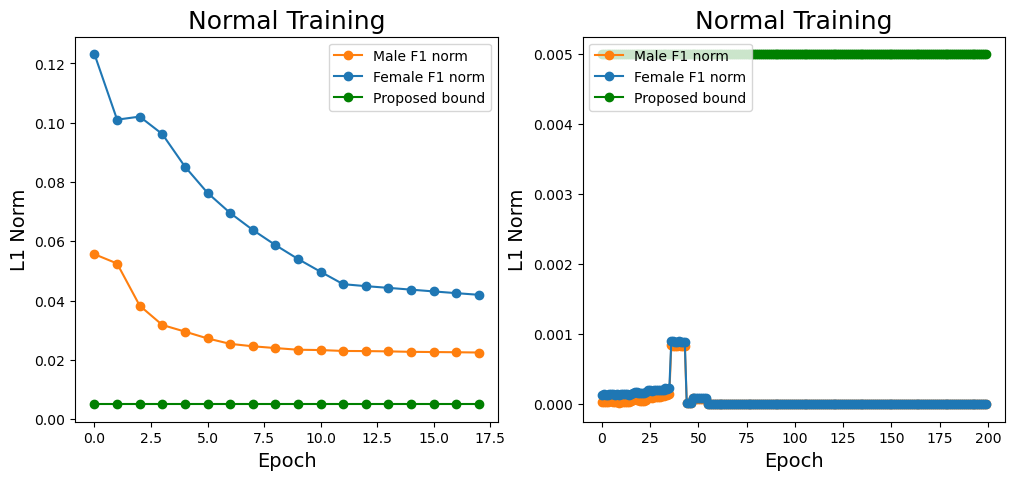

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12,5))

axs[0].plot(
    np.arange(len(run_fair_dict['male_norm'])),
    run_fair_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    run_fair_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[0].plot(
    np.arange(len(run_fair_dict['female_norm'])),
    np.ones(len(run_fair_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[0].set_ylabel('L1 Norm', size=14)
axs[0].set_xlabel('Epoch', size=14)
axs[0].set_title(f'Normal Training',size=18)
axs[0].legend()

axs[1].plot(
    np.arange(len(run_proposed_dict['male_norm'])),
    run_proposed_dict['male_norm'],
    '-o',
    label='Male F1 norm',
    color='#ff7f0e'
)

axs[1].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    run_proposed_dict['female_norm'],
    '-o',
    label='Female F1 norm',
    color='#1f77b4'
)

axs[1].plot(
    np.arange(len(run_proposed_dict['female_norm'])),
    np.ones(len(run_proposed_dict['female_norm']))*bound,
    '-o',
    label='Proposed bound',
    color='green'
)

axs[1].set_ylabel('L1 Norm', size=14)
axs[1].set_xlabel('Epoch', size=14)
axs[1].set_title(f'Normal Training',size=18)
axs[1].legend(loc=2)